# Federated Kaplan-Meier curve
This notebook explains how to calculate a federated Kaplan-Meier curve. The first step is to install the required libraries (when necessary)

In [1]:
! pip install vantage6-client==4.4.1 matplotlib

## Credentials and login
Provide the correct credentials below, to log into a Federated Learning message broker (server). The following variables need to be configured:
- `server_url`: the url where the service is running (without port or subfolder specification)
- `server_port`: the port number where the server can be reached
- `server_api`: the subfolder URL specification needed, default is '/api'
- `username`: username of the researcher on the message broker server
- `password`: password of the researcher on the message broker server
- `organization_key`: if encryption is enabled, the organization key needs to be provided here

In [ ]:
from vantage6.client import Client
import json, time

# Load your configuration settings from a file or environment
config = {
    'server_url': 'http://host.docker.internal',
    'server_port': 5000,
    'server_api': '/api',
    'username': 'alpha-user',
    'password': 'alpha-password',
    'organization_key': None
}

client = Client(config['server_url'], config['server_port'], config['server_api'], log_level='info')
client.authenticate(username=config['username'], password=config['password'])
client.setup_encryption(config['organization_key'])
client.log_level = 'warn'

## Define the task to execute
Now we are logged into the message broker, we can post a request to execute a specific algorithm. In our case to calculate a Kaplan-Meier curve.

To make this happen, we need to specify some information regarding the algorithm to execute. These are algorithm-specific variables:
- `time_column_name`: The column name which represents the time for the right-censored information, e.g. survival time
- `censor_column_name`: the column name which represents the status at the specified time point (e.g. survival yes/no at a specific survival time)
- `organization_ids`: the organizations involved in running the experiment. These are the numeric identifiers of the organizations
- `bin_size`: optional parameter, to fix a specific bin size for the time column

In [3]:
# Determine the first collaboration identifier
collaboration_id = client.collaboration.list()['data'][0]['id']

# Determine the organizations involved in this collaboration
organization_ids = [ ]
for org in client.organization.list(collaboration=collaboration_id)["data"]:
  organization_ids.append(org['id'])

input_ = {
    'method': 'master',
    'kwargs': {
        'time_column_name': 'Survival.time',
        'censor_column_name': 'deadstatus.event',
        'organization_ids': organization_ids, # Example organization IDs
        'bin_size': None  # Or a specific bin size
    }
}

### Execute the task
Now we can execute the task itself. Mind the `image` parameter, which refers to a Docker image which will be pulled (=downloaded) at every data station (=node) and executed. The previously defined input is passed in the `input_` parameter.

In [4]:
task = client.task.create(
    collaboration=collaboration_id,  # Use your specific collaboration ID
    organizations=[client.organization.get()['id']],  # List your organization IDs
    name='Kaplan-Meier Task',  # Give your task a specific name
    image='ghcr.io/mdw-nl/v6-km-studyathon:v0.0.16',  # Specify the desired algorithm Docker image version
    description='Survival analysis using Kaplan-Meier',  # Describe the task
    databases=[{'label': 'default'}],  # Use your database label
    input_=input_
)

## Download and interpret results
In the following steps, we will download the results, and interpret them both in numerical and visual form. The following cell will download the results.

In [5]:
task_info = client.task.get(task['id'], include_results=True)
while not task_info['status']=='completed':
    print("No result (yet) to be retrieved, waiting")
    time.sleep(5)
    task_info = client.task.get(task['id'], include_results=True)

result = client.result.from_task(task['id'])["data"][0]["result"]
result = result.replace("\\", "").strip("\"")
result = json.loads(result)

No result (yet) to be retrieved, waiting
No result (yet) to be retrieved, waiting
No result (yet) to be retrieved, waiting
No result (yet) to be retrieved, waiting
No result (yet) to be retrieved, waiting
No result (yet) to be retrieved, waiting
No result (yet) to be retrieved, waiting
No result (yet) to be retrieved, waiting
--> Attempting to decrypt results!


### Calculate survival percentage
Based on the results, we can retrieve the survival percentage at a given follow-up timepoint. Follow-up time is measured in days, hence the calculation for 2 years would be `365*2`.

In [6]:
target_time = 365*2
res_key, res_val = min(result["Survival.time"].items(), key=lambda x: abs(target_time - x[1]))
res_perc = result["survival_cdf"][res_key]
print(f"The survival percentage for two years after treatment is {(res_perc*100):.0f}%")

The survival percentage for two years after treatment is 42%


### Create Kaplan-Meier plot
Based on the results, produce the kaplan meier plot. Here we also include a crosshair for the follow-up timepoint as retrieved above.

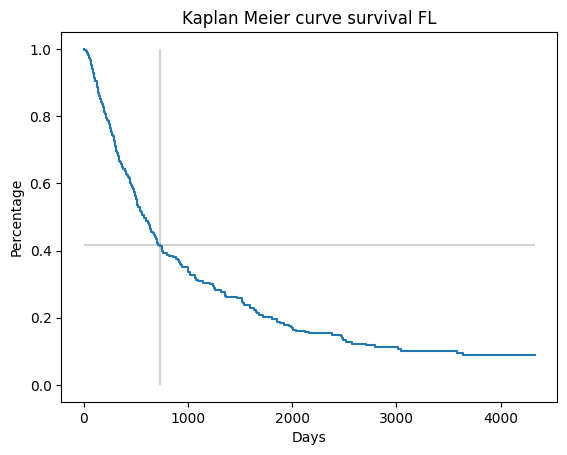

In [7]:
# plot KM curve
import matplotlib.pyplot as plt
plt.vlines(x = target_time, ymin = 0, ymax = 1,
           colors = 'lightgray',
           label = '2-year mark')
plt.hlines(y = res_perc, xmin = 0, xmax = max(result["Survival.time"].values()),
           colors = 'lightgray',
           label = '2-year mark')
plt.step(result["Survival.time"].values(), result["survival_cdf"].values(), linestyle='solid')
plt.xlabel('Days')
plt.ylabel('Percentage')
plt.title('Kaplan Meier curve survival FL')
# plt.savefig('km-plot.png')
plt.show()